# Wind Downscaling


In [1]:
import os
from datetime import date, datetime
from pathlib import Path

from dotenv import load_dotenv

from data.data_generator import BatchGenerator, NaiveDecoder, LocalFileProvider, S3FileProvider
from gan import train, metrics
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
import pandas as pd

Num GPUs Available: 0


## Set configuration

In [2]:
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'
DATA_ROOT.mkdir(parents=True, exist_ok=True)
ERA5_DATA_FOLDER.mkdir(exist_ok=True)
COSMO1_DATA_FOLDER.mkdir(exist_ok=True)
DEM_DATA_FILE.parent.mkdir(exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)
cosmoblurred = True
run_id=datetime.today().strftime('%Y%m%d_%H%M')
data_provider = 'local'

In [3]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2017,1,1)
END_DATE = date(2017,3,31)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 64
# Number of sequences per batch
BATCH_SIZE = 32
# Number of noise channels to add to the image
NOISE_CHANNELS = 20

In [4]:
TOPO_PREDICTORS = ['tpi_500', 'slope', 'aspect']
HOMEMADE_PREDICTORS = ['e_plus', 'e_minus', 'w_speed', 'w_angle']
ERA5_PREDICTORS_SURFACE = ['u10', 'v10', 'blh', 'fsr', 'sp', 'sshf']
ERA5_PREDICTORS_Z500 = ['z']
if cosmoblurred:
    ALL_INPUTS = ['U_10M', 'V_10M'] + HOMEMADE_PREDICTORS + TOPO_PREDICTORS
    input_pattern = 'x_cosmo_{date}.nc'
    run_id = f'{run_id}_cosmo_blurred'
else:
    ALL_INPUTS = ERA5_PREDICTORS_Z500 + ERA5_PREDICTORS_SURFACE + TOPO_PREDICTORS + HOMEMADE_PREDICTORS
    input_pattern = 'x_{date}.nc'
ALL_INPUTS = ['U_10M', 'V_10M']
ALL_OUTPUTS = ['U_10M', 'V_10M']
BATCH_WORKERS = os.cpu_count()
if data_provider == 'local':
    input_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, input_pattern)
    output_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, 'y_{date}.nc')
elif data_provider == 's3':
    input_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern=input_pattern)
    output_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern='y_{date}.nc')
else:
    raise ValueError(f'Wrong value for data provider {data_provider}: please choose between s3 and local')
AVAIL_DATES = [pd.to_datetime(v) for v in
               set(input_provider.available_dates).intersection(output_provider.available_dates)]
START_DATE = min(AVAIL_DATES)
END_DATE = max(AVAIL_DATES)
batch_gen = BatchGenerator(input_provider, output_provider,
                                    decoder=NaiveDecoder(normalize=True),
                                    sequence_length=SEQUENCE_LENGTH,
                                    patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                                    input_variables=ALL_INPUTS,
                                    output_variables=ALL_OUTPUTS,
                                    start_date=START_DATE, end_date=END_DATE,
                                    num_workers=BATCH_WORKERS)
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [5]:
inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")

Creating batch 1/90
Creating batch 2/90
Creating batch 3/90
Creating batch 4/90
Creating batch 5/90
Creating batch 6/90
Creating batch 7/90
Creating batch 8/90
Creating batch 9/90
Creating batch 10/90
Creating batch 11/90
Creating batch 12/90
Creating batch 13/90
Creating batch 14/90
Creating batch 15/90
Creating batch 16/90
Creating batch 17/90
Creating batch 18/90
Creating batch 19/90
Creating batch 20/90
Creating batch 21/90
Creating batch 22/90
Creating batch 23/90
Creating batch 24/90
Creating batch 25/90
Creating batch 26/90
Creating batch 27/90
Creating batch 28/90
Creating batch 29/90
Creating batch 30/90
Creating batch 31/90
Creating batch 32/90
Creating batch 33/90
Creating batch 34/90
Creating batch 35/90
Creating batch 36/90
Creating batch 37/90
Creating batch 38/90
Creating batch 39/90
Creating batch 40/90
Creating batch 41/90
Creating batch 42/90
Creating batch 43/90
Creating batch 44/90
Creating batch 45/90
Creating batch 46/90
Creating batch 47/90
Creating batch 48/90
C

In [6]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [7]:
from gan.models import make_generator, make_discriminator
from gan.ganbase import  GAN
from data.data_generator import FlexibleNoiseGenerator

generator = make_generator(image_size=IMG_SIZE, in_channels=INPUT_CHANNELS,
                           noise_channels=NOISE_CHANNELS, out_channels=OUT_CHANNELS,
                           n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {generator.count_params():,} weights")

discriminator = make_discriminator(low_res_size=IMG_SIZE, high_res_size=IMG_SIZE, low_res_channels=INPUT_CHANNELS,
                                   high_res_channels=OUT_CHANNELS, n_timesteps=SEQUENCE_LENGTH)
print(f"Discriminator: {discriminator.count_params():,} weights")

noise_shape = (BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, NOISE_CHANNELS)
gan = GAN(generator, discriminator, noise_generator=FlexibleNoiseGenerator(noise_shape, std=0.01), n_critic=3)

print(f"Total: {gan.generator.count_params() + gan.discriminator.count_params():,} weights")

Generator: 1,786,962 weights
Discriminator: 3,303,241 weights
Total: 5,090,203 weights


In [9]:
gan.compile(generator_optimizer=train.generator_optimizer(),
            generator_metrics= [tf.keras.metrics.RootMeanSquaredError(), metrics.LogSpectralDistance(),
                                metrics.WeightedRMSEForExtremes(), metrics.WindSpeedWeightedRMSE(),
                                metrics.SpatialKS(), metrics.AngularCosineDistance()],
            discriminator_optimizer=train.discriminator_optimizer(),
                discriminator_loss=train.discriminator_loss,
           metrics = [metrics.discriminator_score_fake(), metrics.discriminator_score_real()])

In [10]:
checkpoint_path_weights = Path('./checkpoints/gan') / run_id / 'weights-{epoch:02d}.ckpt'
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/gan') / run_id
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [11]:
%load_ext tensorboard
%tensorboard --logdir=$log_path

In [12]:
import matplotlib.pyplot as plt
def show(images, dims=1, legends=None):
    fig, axes = plt.subplots(ncols= len(images), figsize=(10, 10))
    for ax, im in zip(axes, images):
        for i in range(dims):
            label = legends[i] if legends is not None else ''
            ax.imshow(im[0, :, :, i], cmap='jet')
            ax.set_title(label)
            ax.axis('off')
    plt.show()
    return fig

In [13]:
class ShowCallback(tf.keras.callbacks.Callback):
    def __init__(self, dims):
        self.dims = dims
        
    def on_epoch_begin(self, epoch, logs):
        noise = FlexibleNoiseGenerator(noise_shape)
        show(self.model.generator([inputs[:self.dims], noise(self.dims)]))

In [14]:
callbacks = [
        cb.TensorBoard(log_path, write_images=True, update_freq='batch'),
        cb.ProgbarLogger('steps'),
        cb.TerminateOnNaN(),
        cb.ModelCheckpoint(str(checkpoint_path_weights), save_best_only=False, period=10,
                           save_weights_only=True),
        ShowCallback(3),
    ]

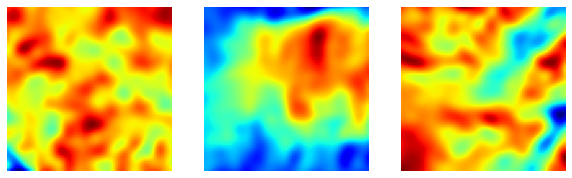

In [15]:
fig = show(inputs[:3])

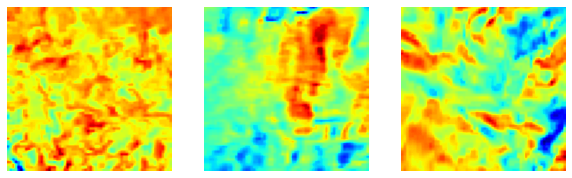

In [16]:
fig = show(outputs[:3])

Epoch 1/50


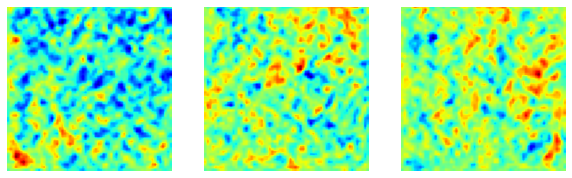

68/68 [==============================] - 1024s 14s/step - d_loss: 2900.5667 - g_loss: -4028.9210 - d_gradient_pen: 15.9489 - d_fake: 1689.7869 - d_real: 569.2055 - g_root_mean_squared_error: 3.4799 - g_lsd: 11.6371 - g_extreme_rmse: 1.0364 - g_ws_weighted_rmse: 4.6518 - g_spatial_ks: 0.7064 - g_acd: 0.5366 - val_loss: -4448.8706 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 2/50


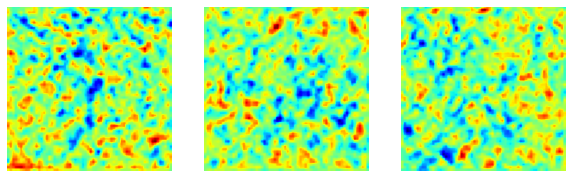

68/68 [==============================] - 956s 14s/step - d_loss: 8226.8107 - g_loss: -11152.2634 - d_gradient_pen: 44.8588 - d_fake: 10323.5692 - d_real: 2503.5929 - g_root_mean_squared_error: 3.5767 - g_lsd: 12.0039 - g_extreme_rmse: 0.9769 - g_ws_weighted_rmse: 4.5409 - g_spatial_ks: 0.7531 - g_acd: 0.5031 - val_loss: -6515.5122 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 3/50


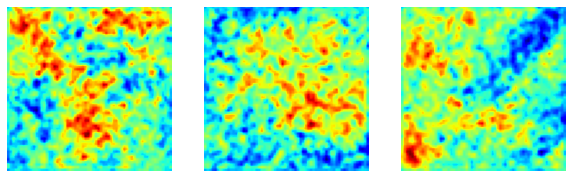

68/68 [==============================] - 995s 15s/step - d_loss: 8986.8172 - g_loss: -13812.0659 - d_gradient_pen: 73.0217 - d_fake: 12624.0534 - d_real: 4133.2377 - g_root_mean_squared_error: 3.7737 - g_lsd: 12.0147 - g_extreme_rmse: 0.9933 - g_ws_weighted_rmse: 4.5813 - g_spatial_ks: 0.7639 - g_acd: 0.4961 - val_loss: -11886.1719 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 4/50


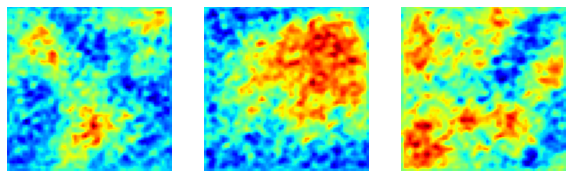

68/68 [==============================] - 994s 15s/step - d_loss: 12529.6147 - g_loss: -19914.2072 - d_gradient_pen: 117.7537 - d_fake: 19461.1615 - d_real: 6869.8682 - g_root_mean_squared_error: 3.7481 - g_lsd: 11.9744 - g_extreme_rmse: 0.9684 - g_ws_weighted_rmse: 4.5573 - g_spatial_ks: 0.7581 - g_acd: 0.4830 - val_loss: -3157.3916 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 5/50


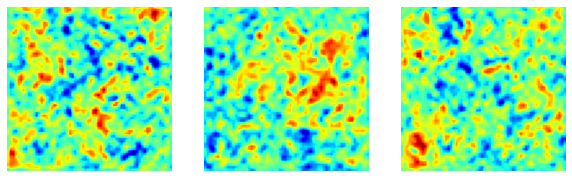

68/68 [==============================] - 988s 15s/step - d_loss: 8890.1536 - g_loss: -15654.1807 - d_gradient_pen: 97.3699 - d_fake: 17937.9432 - d_real: 7710.1110 - g_root_mean_squared_error: 3.7259 - g_lsd: 12.1348 - g_extreme_rmse: 0.9507 - g_ws_weighted_rmse: 4.5244 - g_spatial_ks: 0.7555 - g_acd: 0.4762 - val_loss: -3659.5117 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 6/50


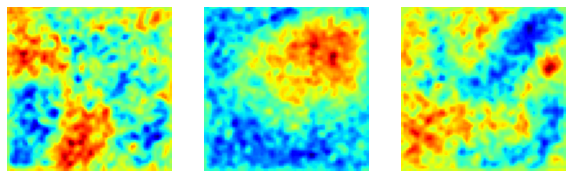

68/68 [==============================] - 971s 14s/step - d_loss: 6635.2596 - g_loss: -10878.8538 - d_gradient_pen: 100.7170 - d_fake: 2128.6613 - d_real: 1183.3052 - g_root_mean_squared_error: 3.7353 - g_lsd: 12.2448 - g_extreme_rmse: 0.9296 - g_ws_weighted_rmse: 4.4834 - g_spatial_ks: 0.7523 - g_acd: 0.4670 - val_loss: -8383.9648 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 7/50


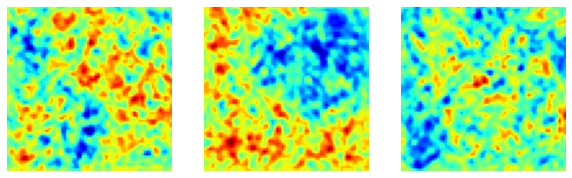

68/68 [==============================] - 948s 14s/step - d_loss: 23692.4402 - g_loss: -36717.5242 - d_gradient_pen: 164.5971 - d_fake: 30225.2436 - d_real: 11283.6725 - g_root_mean_squared_error: 3.6832 - g_lsd: 12.3215 - g_extreme_rmse: 0.9070 - g_ws_weighted_rmse: 4.4271 - g_spatial_ks: 0.7480 - g_acd: 0.4598 - val_loss: -8699.8398 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 8/50


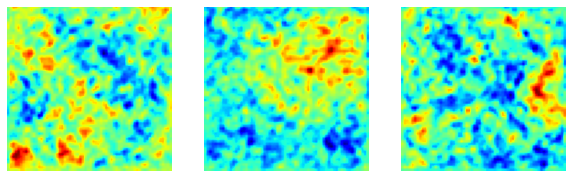

68/68 [==============================] - 937s 14s/step - d_loss: 1238.5217 - g_loss: -3386.3218 - d_gradient_pen: 56.2984 - d_fake: 13094.4690 - d_real: 6558.9746 - g_root_mean_squared_error: 3.6416 - g_lsd: 12.4462 - g_extreme_rmse: 0.8984 - g_ws_weighted_rmse: 4.4065 - g_spatial_ks: 0.7475 - g_acd: 0.4585 - val_loss: 6554.6621 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 9/50


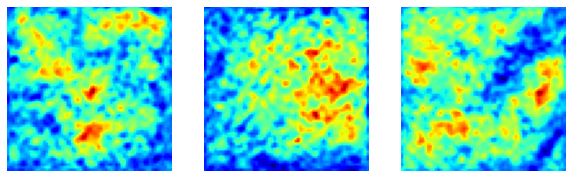

68/68 [==============================] - 941s 14s/step - d_loss: 1830.4048 - g_loss: -1487.4427 - d_gradient_pen: 56.9788 - d_fake: 492.6895 - d_real: -300.3123 - g_root_mean_squared_error: 3.6114 - g_lsd: 12.6124 - g_extreme_rmse: 0.8970 - g_ws_weighted_rmse: 4.3902 - g_spatial_ks: 0.7464 - g_acd: 0.4588 - val_loss: -7083.0332 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 10/50


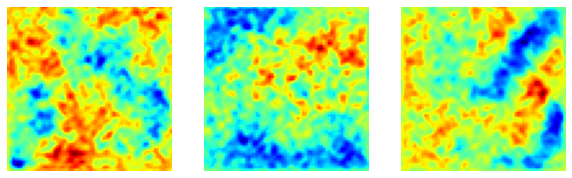

68/68 [==============================] - 941s 14s/step - d_loss: 67.7559 - g_loss: 476.2088 - d_gradient_pen: 18.3471 - d_fake: -260.9390 - d_real: -418.5920 - g_root_mean_squared_error: 3.5805 - g_lsd: 12.7976 - g_extreme_rmse: 0.9023 - g_ws_weighted_rmse: 4.3978 - g_spatial_ks: 0.7454 - g_acd: 0.4622 - val_loss: -1416.6733 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 11/50


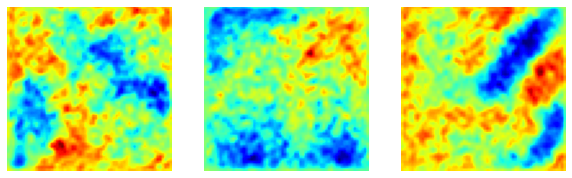

68/68 [==============================] - 952s 14s/step - d_loss: -1015.1586 - g_loss: 4556.5837 - d_gradient_pen: 49.2023 - d_fake: -3277.0742 - d_real: -2807.4272 - g_root_mean_squared_error: 3.5545 - g_lsd: 12.9277 - g_extreme_rmse: 0.8995 - g_ws_weighted_rmse: 4.3965 - g_spatial_ks: 0.7413 - g_acd: 0.4598 - val_loss: -1189.6406 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 12/50


68/68 [==============================] - 986s 14s/step - d_loss: 2018.4829 - g_loss: -1506.2323 - d_gradient_pen: 60.8386 - d_fake: -3805.7197 - d_real: -2487.5645 - g_root_mean_squared_error: 3.5624 - g_lsd: 12.9472 - g_extreme_rmse: 0.8956 - g_ws_weighted_rmse: 4.3915 - g_spatial_ks: 0.7386 - g_acd: 0.4564 - val_loss: -2903.8530 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 13/50


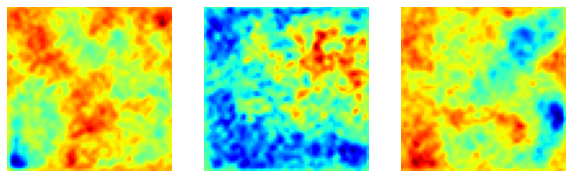

68/68 [==============================] - 1029s 15s/step - d_loss: 19449.9017 - g_loss: -31031.6041 - d_gradient_pen: 149.3095 - d_fake: 30728.1568 - d_real: 9917.2013 - g_root_mean_squared_error: 3.6234 - g_lsd: 12.9375 - g_extreme_rmse: 0.9049 - g_ws_weighted_rmse: 4.4164 - g_spatial_ks: 0.7392 - g_acd: 0.4568 - val_loss: -28554.7676 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 14/50


68/68 [==============================] - 982s 14s/step - d_loss: 16743.7091 - g_loss: -27773.0395 - d_gradient_pen: 168.4404 - d_fake: 32172.9719 - d_real: 12986.4765 - g_root_mean_squared_error: 3.6149 - g_lsd: 13.0080 - g_extreme_rmse: 0.9027 - g_ws_weighted_rmse: 4.4056 - g_spatial_ks: 0.7389 - g_acd: 0.4560 - val_loss: 2057.6187 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 15/50


68/68 [==============================] - 969s 14s/step - d_loss: 39.3101 - g_loss: 1541.6674 - d_gradient_pen: 60.7298 - d_fake: -960.4659 - d_real: -1176.5565 - g_root_mean_squared_error: 3.5630 - g_lsd: 13.0958 - g_extreme_rmse: 0.8949 - g_ws_weighted_rmse: 4.3871 - g_spatial_ks: 0.7358 - g_acd: 0.4545 - val_loss: -7721.2739 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 16/50


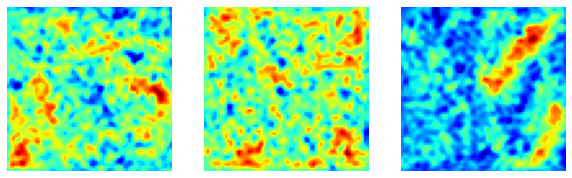

68/68 [==============================] - 951s 14s/step - d_loss: -2321.5030 - g_loss: 7726.7708 - d_gradient_pen: 74.4439 - d_fake: -6892.0756 - d_real: -4839.6047 - g_root_mean_squared_error: 3.5688 - g_lsd: 13.1293 - g_extreme_rmse: 0.8968 - g_ws_weighted_rmse: 4.3929 - g_spatial_ks: 0.7350 - g_acd: 0.4556 - val_loss: -12378.8184 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 17/50


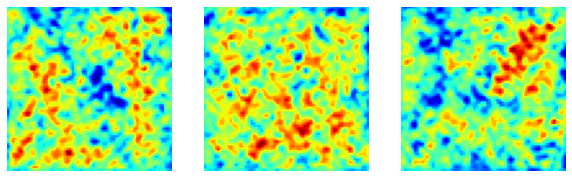

68/68 [==============================] - 941s 14s/step - d_loss: -1104.1685 - g_loss: 7145.1502 - d_gradient_pen: 102.7059 - d_fake: -8920.5386 - d_real: -8039.9875 - g_root_mean_squared_error: 3.6334 - g_lsd: 13.1021 - g_extreme_rmse: 0.9056 - g_ws_weighted_rmse: 4.4292 - g_spatial_ks: 0.7359 - g_acd: 0.4566 - val_loss: -16071.0820 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 18/50


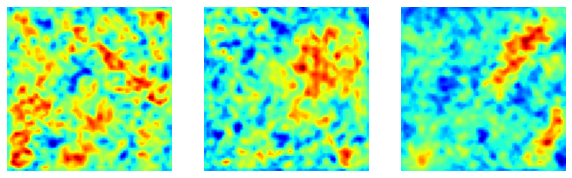

68/68 [==============================] - 947s 14s/step - d_loss: 1664.5487 - g_loss: 3989.5550 - d_gradient_pen: 125.7356 - d_fake: 544.3252 - d_real: -3390.8052 - g_root_mean_squared_error: 3.7007 - g_lsd: 13.0754 - g_extreme_rmse: 0.9130 - g_ws_weighted_rmse: 4.4648 - g_spatial_ks: 0.7375 - g_acd: 0.4574 - val_loss: -303.2627 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 19/50


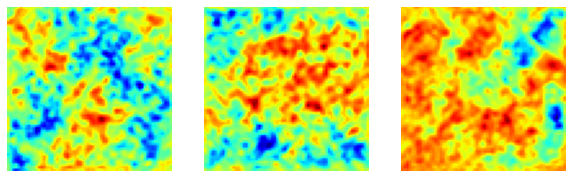

68/68 [==============================] - 953s 14s/step - d_loss: -3123.1666 - g_loss: 8280.4109 - d_gradient_pen: 119.7086 - d_fake: -9744.4450 - d_real: -6288.7572 - g_root_mean_squared_error: 3.7122 - g_lsd: 13.0962 - g_extreme_rmse: 0.9152 - g_ws_weighted_rmse: 4.4735 - g_spatial_ks: 0.7375 - g_acd: 0.4579 - val_loss: -9237.9902 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 20/50


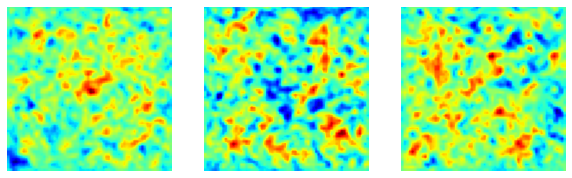

68/68 [==============================] - 947s 14s/step - d_loss: 5068.9941 - g_loss: -4187.8495 - d_gradient_pen: 152.4162 - d_fake: 3311.6626 - d_real: -2595.5911 - g_root_mean_squared_error: 3.7303 - g_lsd: 13.1129 - g_extreme_rmse: 0.9177 - g_ws_weighted_rmse: 4.4847 - g_spatial_ks: 0.7374 - g_acd: 0.4579 - val_loss: -26702.9434 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 21/50


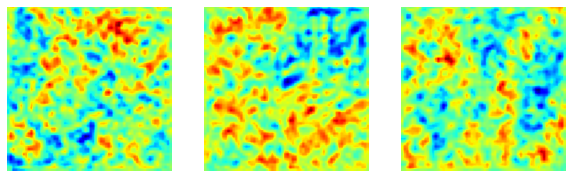

68/68 [==============================] - 948s 14s/step - d_loss: 2031.2946 - g_loss: 4113.4386 - d_gradient_pen: 156.8754 - d_fake: -3018.4182 - d_real: -5054.6520 - g_root_mean_squared_error: 3.7165 - g_lsd: 13.1810 - g_extreme_rmse: 0.9142 - g_ws_weighted_rmse: 4.4776 - g_spatial_ks: 0.7368 - g_acd: 0.4569 - val_loss: -20327.2461 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 22/50


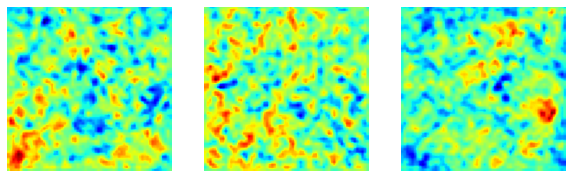

68/68 [==============================] - 944s 14s/step - d_loss: -1294.9571 - g_loss: 11578.8450 - d_gradient_pen: 205.4678 - d_fake: -3506.8262 - d_real: -5382.5895 - g_root_mean_squared_error: 3.7090 - g_lsd: 13.2373 - g_extreme_rmse: 0.9134 - g_ws_weighted_rmse: 4.4782 - g_spatial_ks: 0.7361 - g_acd: 0.4566 - val_loss: -14646.7090 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 23/50


68/68 [==============================] - 946s 14s/step - d_loss: -13142.6920 - g_loss: 36205.1067 - d_gradient_pen: 183.2675 - d_fake: -32341.1378 - d_real: -18330.3015 - g_root_mean_squared_error: 3.7176 - g_lsd: 13.2159 - g_extreme_rmse: 0.9103 - g_ws_weighted_rmse: 4.4749 - g_spatial_ks: 0.7351 - g_acd: 0.4543 - val_loss: -44272.8750 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 24/50


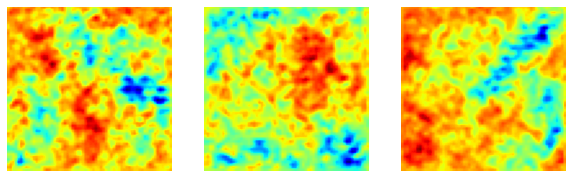

68/68 [==============================] - 943s 14s/step - d_loss: -5411.1855 - g_loss: 25591.7887 - d_gradient_pen: 235.6256 - d_fake: -23635.3131 - d_real: -18700.0539 - g_root_mean_squared_error: 3.7404 - g_lsd: 13.2108 - g_extreme_rmse: 0.9110 - g_ws_weighted_rmse: 4.4839 - g_spatial_ks: 0.7351 - g_acd: 0.4535 - val_loss: 1289.1250 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 25/50


68/68 [==============================] - 944s 14s/step - d_loss: 241.3056 - g_loss: 20323.4533 - d_gradient_pen: 278.1487 - d_fake: -22379.4397 - d_real: -21751.8958 - g_root_mean_squared_error: 3.7313 - g_lsd: 13.2234 - g_extreme_rmse: 0.9094 - g_ws_weighted_rmse: 4.4765 - g_spatial_ks: 0.7328 - g_acd: 0.4534 - val_loss: -25415.2695 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 26/50


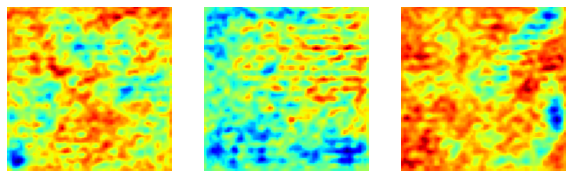

68/68 [==============================] - 960s 14s/step - d_loss: -2936.9494 - g_loss: 25213.8530 - d_gradient_pen: 250.3374 - d_fake: -23653.0304 - d_real: -21495.4654 - g_root_mean_squared_error: 3.7328 - g_lsd: 13.2105 - g_extreme_rmse: 0.9083 - g_ws_weighted_rmse: 4.4766 - g_spatial_ks: 0.7302 - g_acd: 0.4525 - val_loss: -785.9961 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 27/50


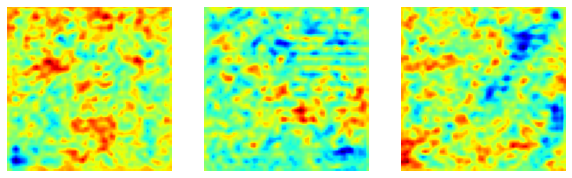

68/68 [==============================] - 953s 14s/step - d_loss: -9196.3476 - g_loss: 27257.9136 - d_gradient_pen: 162.0183 - d_fake: -25656.9139 - d_real: -17327.7312 - g_root_mean_squared_error: 3.7151 - g_lsd: 13.2235 - g_extreme_rmse: 0.9047 - g_ws_weighted_rmse: 4.4700 - g_spatial_ks: 0.7269 - g_acd: 0.4507 - val_loss: -20125.1172 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 28/50


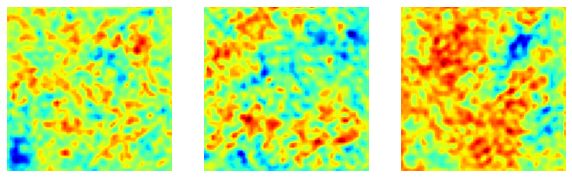

68/68 [==============================] - 942s 14s/step - d_loss: -13100.8535 - g_loss: 39494.4424 - d_gradient_pen: 249.3228 - d_fake: -36770.6160 - d_real: -25794.2358 - g_root_mean_squared_error: 3.7124 - g_lsd: 13.2259 - g_extreme_rmse: 0.9032 - g_ws_weighted_rmse: 4.4711 - g_spatial_ks: 0.7251 - g_acd: 0.4500 - val_loss: -57331.0391 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 29/50


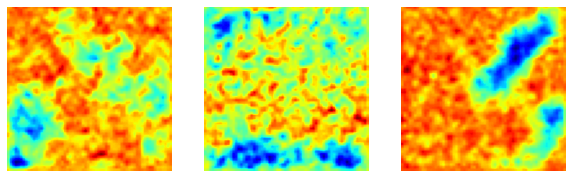

68/68 [==============================] - 941s 14s/step - d_loss: -12343.1702 - g_loss: 36116.2580 - d_gradient_pen: 151.0268 - d_fake: -46658.4649 - d_real: -28195.6815 - g_root_mean_squared_error: 3.7345 - g_lsd: 13.1904 - g_extreme_rmse: 0.9042 - g_ws_weighted_rmse: 4.4821 - g_spatial_ks: 0.7244 - g_acd: 0.4492 - val_loss: 8716.1602 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 30/50


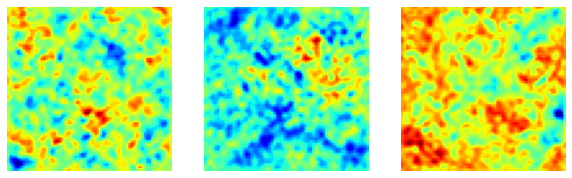

68/68 [==============================] - 939s 14s/step - d_loss: -22222.8115 - g_loss: 48790.8681 - d_gradient_pen: 155.3024 - d_fake: -3808.8538 - d_real: -1855.6505 - g_root_mean_squared_error: 3.7165 - g_lsd: 13.2292 - g_extreme_rmse: 0.9002 - g_ws_weighted_rmse: 4.4721 - g_spatial_ks: 0.7220 - g_acd: 0.4469 - val_loss: -48514.7188 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 31/50


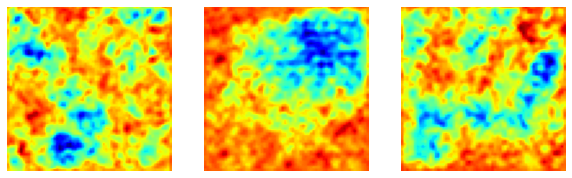

68/68 [==============================] - 946s 14s/step - d_loss: -22722.3813 - g_loss: 62742.5618 - d_gradient_pen: 221.5660 - d_fake: -66194.0024 - d_real: -43542.5140 - g_root_mean_squared_error: 3.7106 - g_lsd: 13.2731 - g_extreme_rmse: 0.8981 - g_ws_weighted_rmse: 4.4686 - g_spatial_ks: 0.7210 - g_acd: 0.4460 - val_loss: -312.8905 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 32/50


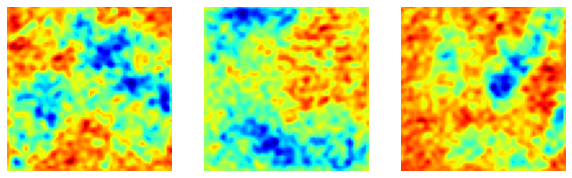

68/68 [==============================] - 947s 14s/step - d_loss: 52525.9703 - g_loss: -94025.0032 - d_gradient_pen: 283.6378 - d_fake: 81563.8423 - d_real: 33314.7437 - g_root_mean_squared_error: 3.7162 - g_lsd: 13.3005 - g_extreme_rmse: 0.8979 - g_ws_weighted_rmse: 4.4766 - g_spatial_ks: 0.7208 - g_acd: 0.4457 - val_loss: 381.4297 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 33/50


68/68 [==============================] - 941s 14s/step - d_loss: -8550.3173 - g_loss: 29318.0276 - d_gradient_pen: 277.0861 - d_fake: -2124.4305 - d_real: -4531.6193 - g_root_mean_squared_error: 3.7228 - g_lsd: 13.2956 - g_extreme_rmse: 0.8970 - g_ws_weighted_rmse: 4.4792 - g_spatial_ks: 0.7208 - g_acd: 0.4447 - val_loss: -65064.3555 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 34/50


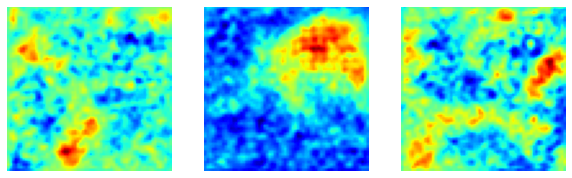

68/68 [==============================] - 942s 14s/step - d_loss: -11990.6871 - g_loss: 44154.0500 - d_gradient_pen: 320.4706 - d_fake: -45785.0147 - d_real: -34602.5078 - g_root_mean_squared_error: 3.7258 - g_lsd: 13.2747 - g_extreme_rmse: 0.8967 - g_ws_weighted_rmse: 4.4789 - g_spatial_ks: 0.7208 - g_acd: 0.4446 - val_loss: -57658.9062 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 35/50


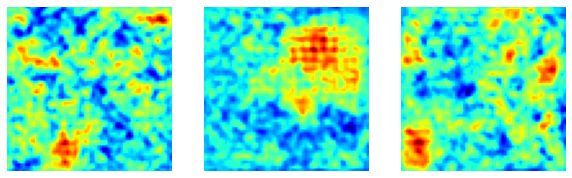

68/68 [==============================] - 944s 14s/step - d_loss: -17830.4335 - g_loss: 53013.7771 - d_gradient_pen: 305.1996 - d_fake: -46554.4848 - d_real: -34611.9318 - g_root_mean_squared_error: 3.7419 - g_lsd: 13.2311 - g_extreme_rmse: 0.8984 - g_ws_weighted_rmse: 4.4868 - g_spatial_ks: 0.7206 - g_acd: 0.4449 - val_loss: -259.0117 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 36/50


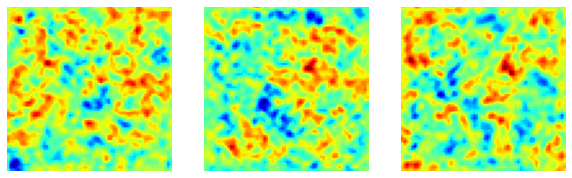

68/68 [==============================] - 955s 14s/step - d_loss: -25227.5856 - g_loss: 70198.9199 - d_gradient_pen: 240.6050 - d_fake: -58262.2559 - d_real: -38983.4070 - g_root_mean_squared_error: 3.7446 - g_lsd: 13.2115 - g_extreme_rmse: 0.8976 - g_ws_weighted_rmse: 4.4906 - g_spatial_ks: 0.7190 - g_acd: 0.4441 - val_loss: -60610.5625 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 37/50


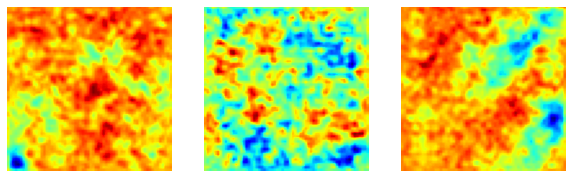

68/68 [==============================] - 953s 14s/step - d_loss: -44353.3609 - g_loss: 109099.2412 - d_gradient_pen: 274.4042 - d_fake: -71675.4712 - d_real: -48631.1920 - g_root_mean_squared_error: 3.7291 - g_lsd: 13.2202 - g_extreme_rmse: 0.8946 - g_ws_weighted_rmse: 4.4827 - g_spatial_ks: 0.7172 - g_acd: 0.4432 - val_loss: 17918.5312 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 38/50


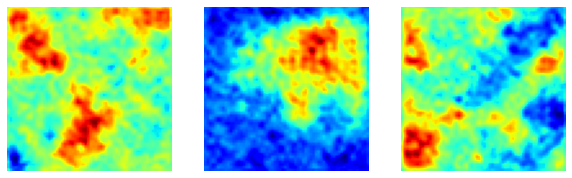

68/68 [==============================] - 950s 14s/step - d_loss: -81988.6925 - g_loss: 181638.8220 - d_gradient_pen: 366.9826 - d_fake: -190796.7629 - d_real: -102661.0046 - g_root_mean_squared_error: 3.7436 - g_lsd: 13.2038 - g_extreme_rmse: 0.8957 - g_ws_weighted_rmse: 4.4904 - g_spatial_ks: 0.7167 - g_acd: 0.4430 - val_loss: -37052.5391 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 39/50


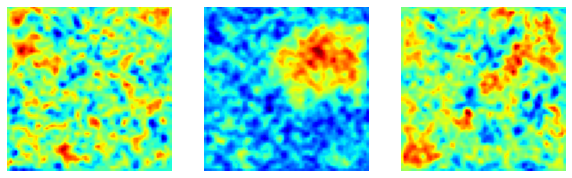

68/68 [==============================] - 949s 14s/step - d_loss: -58888.2959 - g_loss: 139810.4459 - d_gradient_pen: 375.5515 - d_fake: -127384.4613 - d_real: -75003.7313 - g_root_mean_squared_error: 3.7795 - g_lsd: 13.1732 - g_extreme_rmse: 0.8993 - g_ws_weighted_rmse: 4.5083 - g_spatial_ks: 0.7169 - g_acd: 0.4427 - val_loss: -17638.0000 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 40/50


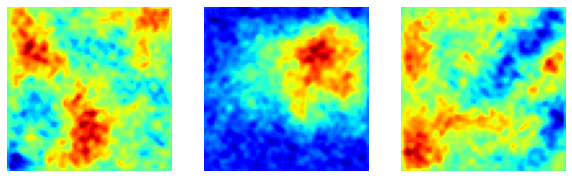

68/68 [==============================] - 948s 14s/step - d_loss: -47054.9997 - g_loss: 125938.2301 - d_gradient_pen: 320.7078 - d_fake: -137830.5725 - d_real: -86440.0901 - g_root_mean_squared_error: 3.8040 - g_lsd: 13.1623 - g_extreme_rmse: 0.9018 - g_ws_weighted_rmse: 4.5234 - g_spatial_ks: 0.7169 - g_acd: 0.4426 - val_loss: -14891.0625 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 41/50


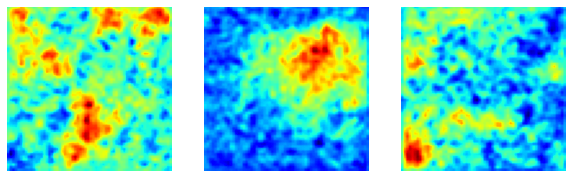

68/68 [==============================] - 947s 14s/step - d_loss: -26097.8640 - g_loss: 69986.2442 - d_gradient_pen: 329.4110 - d_fake: -77732.3925 - d_real: -51331.7725 - g_root_mean_squared_error: 3.8333 - g_lsd: 13.1684 - g_extreme_rmse: 0.9052 - g_ws_weighted_rmse: 4.5430 - g_spatial_ks: 0.7175 - g_acd: 0.4427 - val_loss: -7415.7734 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 42/50


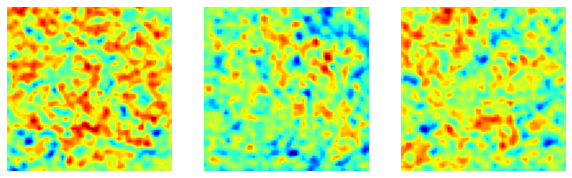

68/68 [==============================] - 941s 14s/step - d_loss: -34305.6673 - g_loss: 86675.4004 - d_gradient_pen: 421.9167 - d_fake: -89218.0591 - d_real: -51708.2486 - g_root_mean_squared_error: 3.8683 - g_lsd: 13.1458 - g_extreme_rmse: 0.9084 - g_ws_weighted_rmse: 4.5626 - g_spatial_ks: 0.7182 - g_acd: 0.4427 - val_loss: -48786.2422 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 43/50


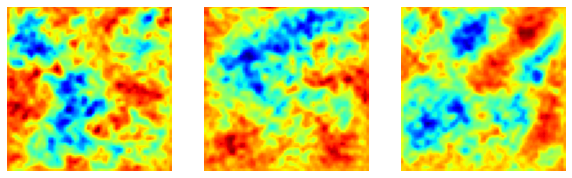

68/68 [==============================] - 945s 14s/step - d_loss: -20469.6829 - g_loss: 71824.2960 - d_gradient_pen: 393.4422 - d_fake: -89492.0092 - d_real: -54169.8317 - g_root_mean_squared_error: 3.9019 - g_lsd: 13.1203 - g_extreme_rmse: 0.9122 - g_ws_weighted_rmse: 4.5815 - g_spatial_ks: 0.7182 - g_acd: 0.4429 - val_loss: -10677.9102 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 44/50


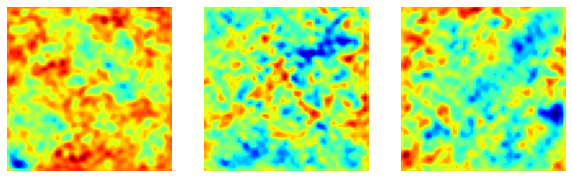

68/68 [==============================] - 955s 14s/step - d_loss: -121567.4770 - g_loss: 252904.9191 - d_gradient_pen: 332.1699 - d_fake: -191739.0137 - d_real: -105898.0161 - g_root_mean_squared_error: 3.9094 - g_lsd: 13.1263 - g_extreme_rmse: 0.9125 - g_ws_weighted_rmse: 4.5879 - g_spatial_ks: 0.7179 - g_acd: 0.4428 - val_loss: -14562.9062 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 45/50


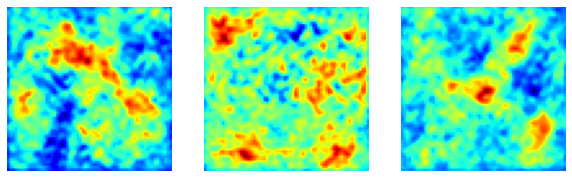

68/68 [==============================] - 947s 14s/step - d_loss: -85627.5366 - g_loss: 193232.6145 - d_gradient_pen: 438.1111 - d_fake: -211495.9803 - d_real: -119519.8046 - g_root_mean_squared_error: 3.9448 - g_lsd: 13.1016 - g_extreme_rmse: 0.9162 - g_ws_weighted_rmse: 4.6076 - g_spatial_ks: 0.7183 - g_acd: 0.4427 - val_loss: -102590.0312 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 46/50


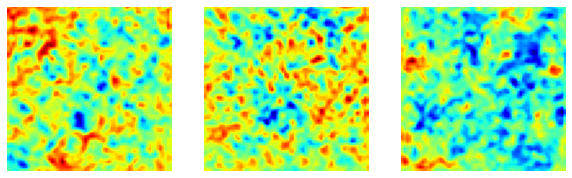

68/68 [==============================] - 951s 14s/step - d_loss: 75975.5307 - g_loss: -112078.6380 - d_gradient_pen: 523.2223 - d_fake: -79494.8677 - d_real: -56858.5730 - g_root_mean_squared_error: 3.9832 - g_lsd: 13.0876 - g_extreme_rmse: 0.9197 - g_ws_weighted_rmse: 4.6292 - g_spatial_ks: 0.7189 - g_acd: 0.4430 - val_loss: -93048.3125 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 47/50


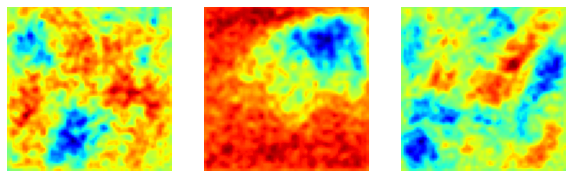

68/68 [==============================] - 943s 14s/step - d_loss: 157298.6972 - g_loss: -307724.0328 - d_gradient_pen: 517.9155 - d_fake: 313396.0548 - d_real: 156101.0480 - g_root_mean_squared_error: 4.0251 - g_lsd: 13.0763 - g_extreme_rmse: 0.9237 - g_ws_weighted_rmse: 4.6530 - g_spatial_ks: 0.7192 - g_acd: 0.4429 - val_loss: -59353.0625 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 48/50


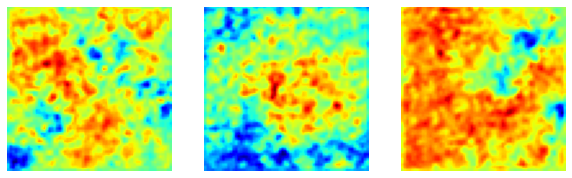

68/68 [==============================] - 958s 14s/step - d_loss: 178404.4139 - g_loss: -337243.2686 - d_gradient_pen: 756.3514 - d_fake: 357595.2948 - d_real: 161324.6218 - g_root_mean_squared_error: 4.0671 - g_lsd: 13.0512 - g_extreme_rmse: 0.9280 - g_ws_weighted_rmse: 4.6761 - g_spatial_ks: 0.7195 - g_acd: 0.4430 - val_loss: -71713.9375 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 49/50


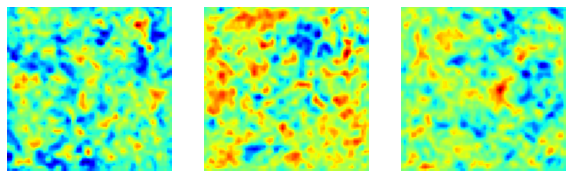

68/68 [==============================] - 953s 14s/step - d_loss: 208904.6760 - g_loss: -387962.2088 - d_gradient_pen: 748.9798 - d_fake: 376278.9402 - d_real: 170490.9019 - g_root_mean_squared_error: 4.0946 - g_lsd: 13.0336 - g_extreme_rmse: 0.9313 - g_ws_weighted_rmse: 4.6922 - g_spatial_ks: 0.7198 - g_acd: 0.4432 - val_loss: -80380.6250 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 50/50


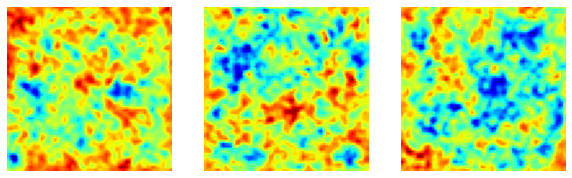

68/68 [==============================] - 940s 14s/step - d_loss: 200497.9266 - g_loss: -375045.9452 - d_gradient_pen: 792.5454 - d_fake: 370975.4022 - d_real: 175080.5038 - g_root_mean_squared_error: 4.1231 - g_lsd: 13.0201 - g_extreme_rmse: 0.9344 - g_ws_weighted_rmse: 4.7096 - g_spatial_ks: 0.7199 - g_acd: 0.4431 - val_loss: -12252.4375 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00


In [17]:
gan.fit(inputs, outputs, callbacks=callbacks, epochs=50, batch_size=BATCH_SIZE, validation_split=0.25)